# **TOPIC:** Maps with Interrupted Goode Homolosine Projection (Book Version)

## **Author:** JM
## **Date:** 02-16-2026
### **Notes**: Goode Homolosine ("unpeeled orange") versions of all maps from the Cultures in Crisis replication notebook.

In [28]:
import os
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
import mapclassify
from matplotlib.patches import Patch
from pathlib import Path
import matplotlib.patches as mpatches
from matplotlib.font_manager import FontProperties
import cartopy.crs as ccrs
import cartopy.feature as cfeature

## - Setting paths and importing shapes

In [29]:
# Set base project path
base_path = Path("C:/Users/juami/Dropbox/RAships/2-Folklore-Nathan-Project/EA-Maps-Nathan-project/Measures_work")

# Set file paths
precol_path = base_path / "maps" / "interim" / "pre_columbian_update" / "world_thiessen_UPDATE" / "EAESW_XY_World_Thiessen_MurdockUpdate_EAinfo.gpkg"
poscol_path = base_path / "data" / "raw" / "ethnologue" / "ancestral_characteristics_database_language_level" / "Ethnologue_16_shapefile" / "langa_no_overlap_biggest_clean.shp"

basemap_path = base_path / "maps" / "interim" / "World" / "world_dissolve_nolakes.shp"

data_path = base_path / "data" / "interim"

export_path = base_path / "deliveries" / "cultures_in_crisis_maps"

In [30]:
# Read the shapefiles and CSV files
precol_shape = gpd.read_file(precol_path)
poscol_shape = gpd.read_file(poscol_path)
basemap_shape = gpd.read_file(basemap_path)

In [31]:
print(precol_shape.crs)
print(poscol_shape.crs) 
print(basemap_shape.crs)

EPSG:4326
EPSG:4326
EPSG:4326


### Fixing Pre-Columbian shape

In [32]:
# Fixing the high gods variable
highGods_fillin_df = pd.read_csv(data_path / "high_gods_fillin_thiessen.csv")
precol_shape = precol_shape.merge(highGods_fillin_df, left_on='v107', right_on='v107', how='left')

precol_shape['v34'] = precol_shape['v34'].replace(0, np.nan)
precol_shape['v66'] = precol_shape['v66'].replace(0, np.nan)
precol_shape['v54'] = precol_shape['v54'].replace(0, np.nan)
precol_shape['v34_fill'] = precol_shape['v34_fill'].replace(0, np.nan)

In [33]:
precol_shape[['v34_fill', 'v34']].head()

v34_fill  v34
0       NaN  NaN
1       4.0  4.0
2       4.0  4.0
3       1.0  1.0
4       NaN  NaN

In [34]:
#Fixing ancestor variable
ancestor_df = pd.read_csv(data_path / "EA_folklore_ancestor_sh.csv")
precol_shape = precol_shape.merge(ancestor_df, left_on='v107', right_on='v107', how='left')

### Fixing Pos-Columbian shape

In [35]:
# Fixing the variables to shape
folk_poscol_df = pd.read_csv(data_path / "Motifs_EA_WESEE_Ethnologue_humanvsnature_all.csv", encoding='latin1')

poscol_shape = poscol_shape.merge(folk_poscol_df, left_on='ID', right_on='id', how='left')

poscol_shape['v34'] = poscol_shape['v34'].replace(0, np.nan)
poscol_shape['v66'] = poscol_shape['v66'].replace(0, np.nan)
poscol_shape['v54'] = poscol_shape['v54'].replace(0, np.nan)

## - Replicating the maps (Goode Homolosine Projection)

In [36]:
# Setting the color palette for all the maps (Blues)
def truncate_colormap(cmap_name='Blues', minval=0.3, maxval=1.0, n=100):
    cmap = plt.get_cmap(cmap_name)
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
        f'{cmap_name}_trunc', cmap(np.linspace(minval, maxval, n)))
    return new_cmap

# Create a stronger Blues (skip the lightest 30%)
strong_bupu = truncate_colormap('Blues', 0.3, 1.0)

In [37]:
# Helper function for Goode Homolosine maps with categorical variables
def plot_goode_categorical(shape_df, var_col, label_map, title, filename, cmap=None, reverse=False):
    """Plot a categorical variable on a Goode Homolosine projection."""
    if cmap is None:
        cmap = strong_bupu
    
    categories = shape_df[var_col].dropna().unique()
    categories = sorted(categories)
    
    n = len(categories)
    if reverse:
        category_colors = cmap(np.linspace(1, 0, n))
    else:
        category_colors = cmap(np.linspace(0, 1, n))
    category_color_map = dict(zip(categories, category_colors))
    
    goode = ccrs.InterruptedGoodeHomolosine()
    fig, ax = plt.subplots(1, 1, figsize=(16, 8), facecolor='white',
                            subplot_kw={'projection': goode})
    
    ax.add_feature(cfeature.LAND, color='lightgray', edgecolor='none', zorder=0)
    
    # Batch geometries by category — repair invalid geometries with buffer(0)
    for cat in categories:
        subset = shape_df[shape_df[var_col] == cat]
        geoms = []
        for g in subset.geometry:
            if g is None:
                continue
            if not g.is_valid:
                g = g.buffer(0)
            geoms.append(g)
        if geoms:
            ax.add_geometries(geoms, crs=ccrs.PlateCarree(),
                              facecolor=category_color_map[cat], edgecolor='none', zorder=1)
    
    # Missing values (NaN)
    missing = shape_df[shape_df[var_col].isna()]
    geoms_missing = []
    for g in missing.geometry:
        if g is None:
            continue
        if not g.is_valid:
            g = g.buffer(0)
        geoms_missing.append(g)
    if geoms_missing:
        ax.add_geometries(geoms_missing, crs=ccrs.PlateCarree(),
                          facecolor='gray', edgecolor='none', zorder=1)
    
    legend_elements = [
        Patch(facecolor=category_color_map[c], label=label_map.get(c, str(c)))
        for c in categories
    ]
    legend_elements.append(Patch(facecolor='gray', label="Missing"))
    legend_elements.append(Patch(facecolor='lightgray', label="Uninhabited"))
    
    ax.legend(handles=legend_elements, loc='lower left',
              bbox_to_anchor=(0.02, 0.08), frameon=False,
              title=title,
              title_fontproperties=FontProperties(weight='bold', size=12),
              prop=FontProperties(size=10))
    
    ax.set_global()
    ax.set_axis_off()
    
    plt.savefig(export_path / filename, format='pdf', dpi=300, bbox_inches='tight')
    plt.show()
    
    return category_color_map, categories

In [38]:
# Helper function for Goode Homolosine maps with quantile variables
def plot_goode_quantile(shape_df, var_col, num_quantiles, title, filename, cmap=None):
    """Plot a quantile variable on a Goode Homolosine projection."""
    if cmap is None:
        cmap = strong_bupu
    
    shape_df['quantile_cat'], bins = pd.qcut(shape_df[var_col], q=num_quantiles, 
                                              retbins=True, labels=False, duplicates='drop')
    
    label_map = {
        i: f"{bins[i]:.2f} - {bins[i+1]:.2f}"
        for i in range(len(bins) - 1)
    }
    
    categories = shape_df['quantile_cat'].dropna().unique()
    categories = sorted(categories)
    
    n = len(categories)
    category_colors = cmap(np.linspace(0, 1, n))
    category_color_map = dict(zip(categories, category_colors))
    
    goode = ccrs.InterruptedGoodeHomolosine()
    fig, ax = plt.subplots(1, 1, figsize=(16, 8), facecolor='white',
                            subplot_kw={'projection': goode})
    
    ax.add_feature(cfeature.LAND, color='lightgray', edgecolor='none', zorder=0)
    
    # Batch geometries by category — repair invalid geometries with buffer(0)
    for cat in categories:
        subset = shape_df[shape_df['quantile_cat'] == cat]
        geoms = []
        for g in subset.geometry:
            if g is None:
                continue
            if not g.is_valid:
                g = g.buffer(0)
            geoms.append(g)
        if geoms:
            ax.add_geometries(geoms, crs=ccrs.PlateCarree(),
                              facecolor=category_color_map[cat], edgecolor='none', zorder=1)
    
    # Missing values (NaN)
    missing = shape_df[shape_df['quantile_cat'].isna()]
    geoms_missing = []
    for g in missing.geometry:
        if g is None:
            continue
        if not g.is_valid:
            g = g.buffer(0)
        geoms_missing.append(g)
    if geoms_missing:
        ax.add_geometries(geoms_missing, crs=ccrs.PlateCarree(),
                          facecolor='gray', edgecolor='none', zorder=1)
    
    legend_elements = [
        Patch(facecolor=category_color_map[c], label=label_map.get(c, str(c)))
        for c in categories
    ]
    legend_elements.append(Patch(facecolor='gray', label="Missing"))
    legend_elements.append(Patch(facecolor='lightgray', label="Uninhabited"))
    
    ax.legend(handles=legend_elements, loc='lower left',
              bbox_to_anchor=(0.02, 0.08), frameon=False,
              title=title,
              title_fontproperties=FontProperties(weight='bold', size=12),
              prop=FontProperties(size=10))
    
    ax.set_global()
    ax.set_axis_off()
    
    plt.savefig(export_path / filename, format='pdf', dpi=300, bbox_inches='tight')
    plt.show()
    
    return bins, label_map, category_color_map, categories


def plot_goode_quantile_with_bins(shape_df, var_col, bins, label_map, title, filename, cmap=None):
    """Plot a quantile variable on a Goode Homolosine using pre-computed bins."""
    if cmap is None:
        cmap = strong_bupu
    
    shape_df['quantile_cat'] = pd.cut(shape_df[var_col], bins=bins, 
                                       labels=False, include_lowest=True)
    
    categories = shape_df['quantile_cat'].dropna().unique()
    categories = sorted(categories)
    
    n = len(categories)
    category_colors = cmap(np.linspace(0, 1, n))
    category_color_map = dict(zip(categories, category_colors))
    
    goode = ccrs.InterruptedGoodeHomolosine()
    fig, ax = plt.subplots(1, 1, figsize=(16, 8), facecolor='white',
                            subplot_kw={'projection': goode})
    
    ax.add_feature(cfeature.LAND, color='lightgray', edgecolor='none', zorder=0)
    
    # Batch geometries by category — repair invalid geometries with buffer(0)
    for cat in categories:
        subset = shape_df[shape_df['quantile_cat'] == cat]
        geoms = []
        for g in subset.geometry:
            if g is None:
                continue
            if not g.is_valid:
                g = g.buffer(0)
            geoms.append(g)
        if geoms:
            ax.add_geometries(geoms, crs=ccrs.PlateCarree(),
                              facecolor=category_color_map[cat], edgecolor='none', zorder=1)
    
    # Missing values (NaN)
    missing = shape_df[shape_df['quantile_cat'].isna()]
    geoms_missing = []
    for g in missing.geometry:
        if g is None:
            continue
        if not g.is_valid:
            g = g.buffer(0)
        geoms_missing.append(g)
    if geoms_missing:
        ax.add_geometries(geoms_missing, crs=ccrs.PlateCarree(),
                          facecolor='gray', edgecolor='none', zorder=1)
    
    legend_elements = [
        Patch(facecolor=category_color_map[c], label=label_map.get(c, str(c)))
        for c in categories
    ]
    legend_elements.append(Patch(facecolor='gray', label="Missing"))
    legend_elements.append(Patch(facecolor='lightgray', label="Uninhabited"))
    
    ax.legend(handles=legend_elements, loc='lower left',
              bbox_to_anchor=(0.02, 0.08), frameon=False,
              title=title,
              title_fontproperties=FontProperties(weight='bold', size=12),
              prop=FontProperties(size=10))
    
    ax.set_global()
    ax.set_axis_off()
    
    plt.savefig(export_path / filename, format='pdf', dpi=300, bbox_inches='tight')
    plt.show()

### -- Map 1: High Gods

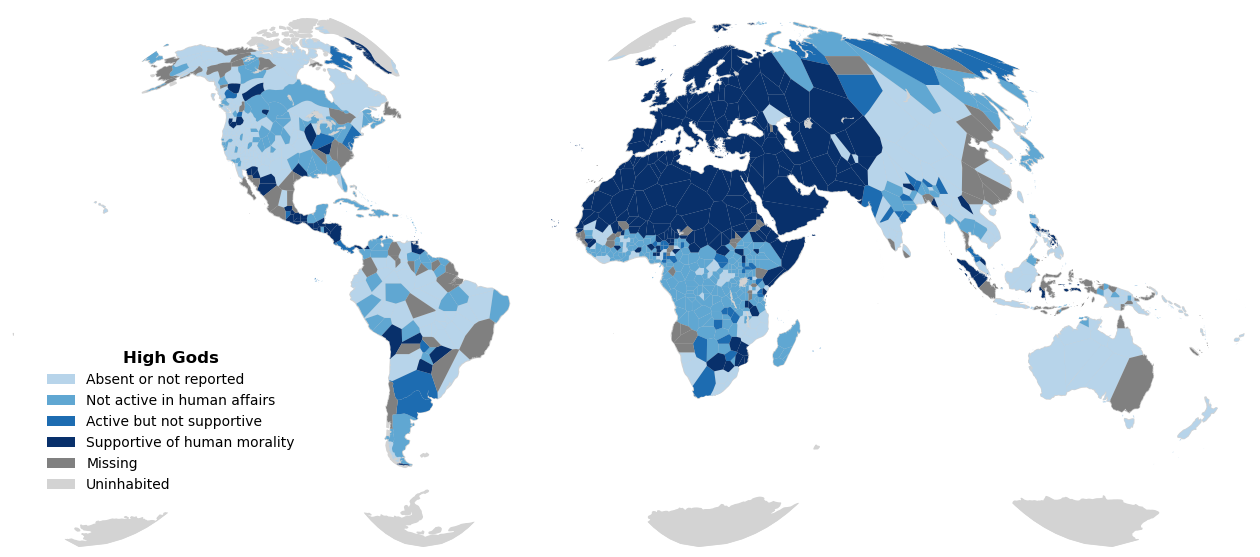

({np.float64(1.0): array([0.71618608, 0.83320261, 0.91615532, 1.        ]),
  np.float64(2.0): array([0.37673203, 0.6530719 , 0.82248366, 1.        ]),
  np.float64(3.0): array([0.114802  , 0.42443676, 0.69519416, 1.        ]),
  np.float64(4.0): array([0.03137255, 0.18823529, 0.41960784, 1.        ])},
 [np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0)])

In [39]:
# High Gods - Pre-Columbian (Goode Homolosine)
label_map_highgods = {
    1: "Absent or not reported",
    2: "Not active in human affairs",
    3: "Active but not supportive",
    4: "Supportive of human morality"
}

plot_goode_categorical(precol_shape, 'v34', label_map_highgods, 
                       "High Gods", "Replication_HighGods_PRECOL_Goode.pdf")

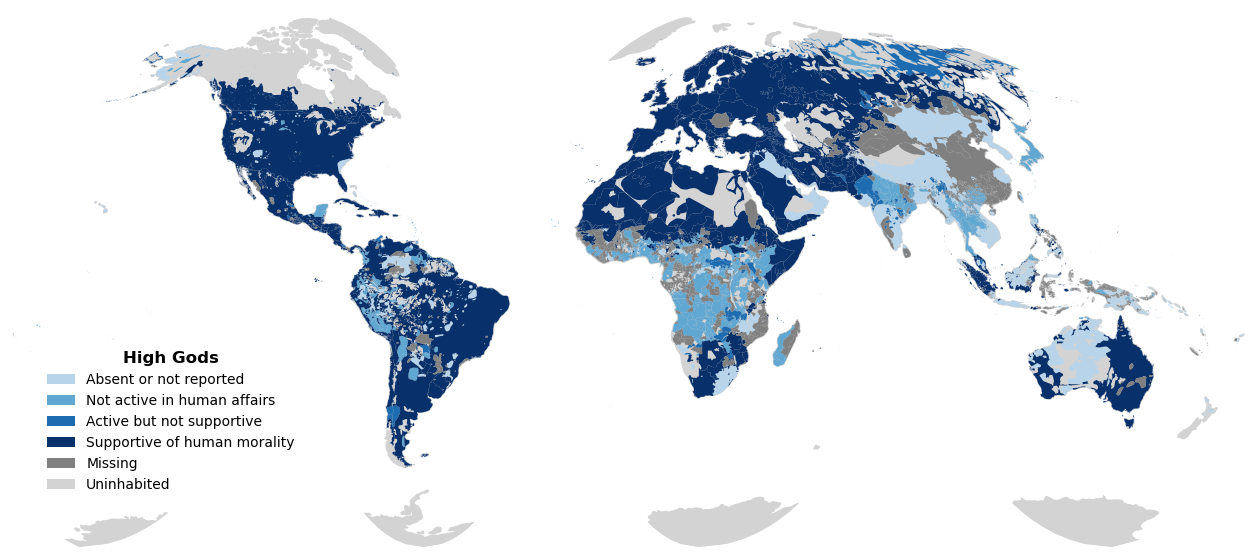

({np.float64(1.0): array([0.71618608, 0.83320261, 0.91615532, 1.        ]),
  np.float64(2.0): array([0.37673203, 0.6530719 , 0.82248366, 1.        ]),
  np.float64(3.0): array([0.114802  , 0.42443676, 0.69519416, 1.        ]),
  np.float64(4.0): array([0.03137255, 0.18823529, 0.41960784, 1.        ])},
 [np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0)])

In [40]:
# High Gods - Pos-Columbian (Goode Homolosine)
plot_goode_categorical(poscol_shape, 'v34', label_map_highgods,
                       "High Gods", "Replication_HighGods_POSCOL_Goode.pdf")

### -- Map 2: Ancestors

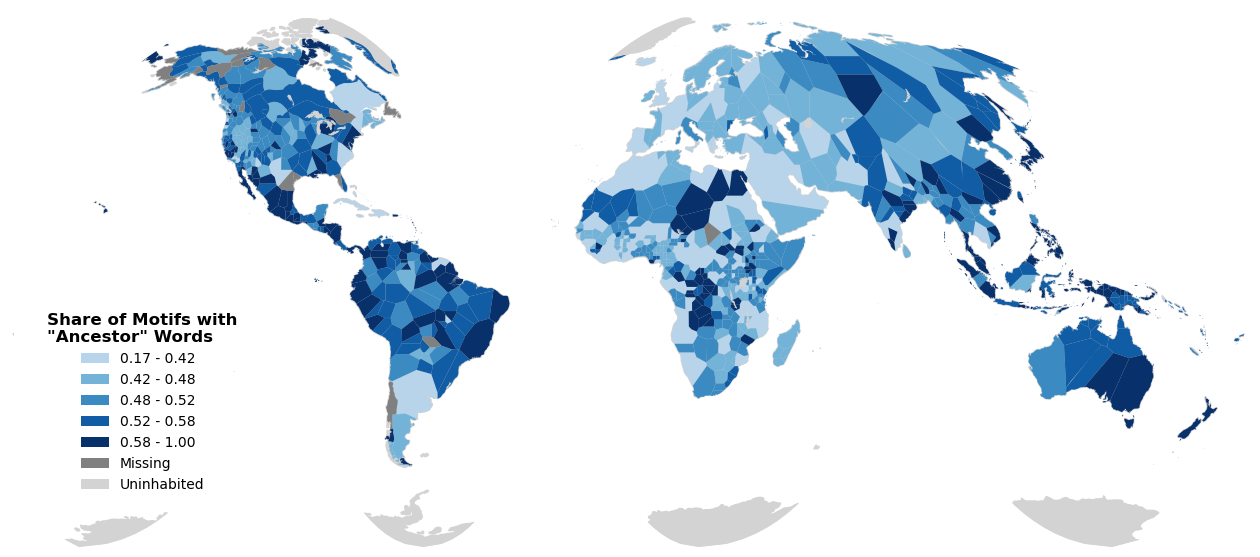

In [41]:
# Ancestors - Pre-Columbian (Goode Homolosine)
bins_anc, label_map_anc, _, _ = plot_goode_quantile(
    precol_shape, 'ancestor_sh', 5,
    "Share of Motifs with\n\"Ancestor\" Words",
    "Replication_AncestorSh_PRECOL_Goode.pdf")

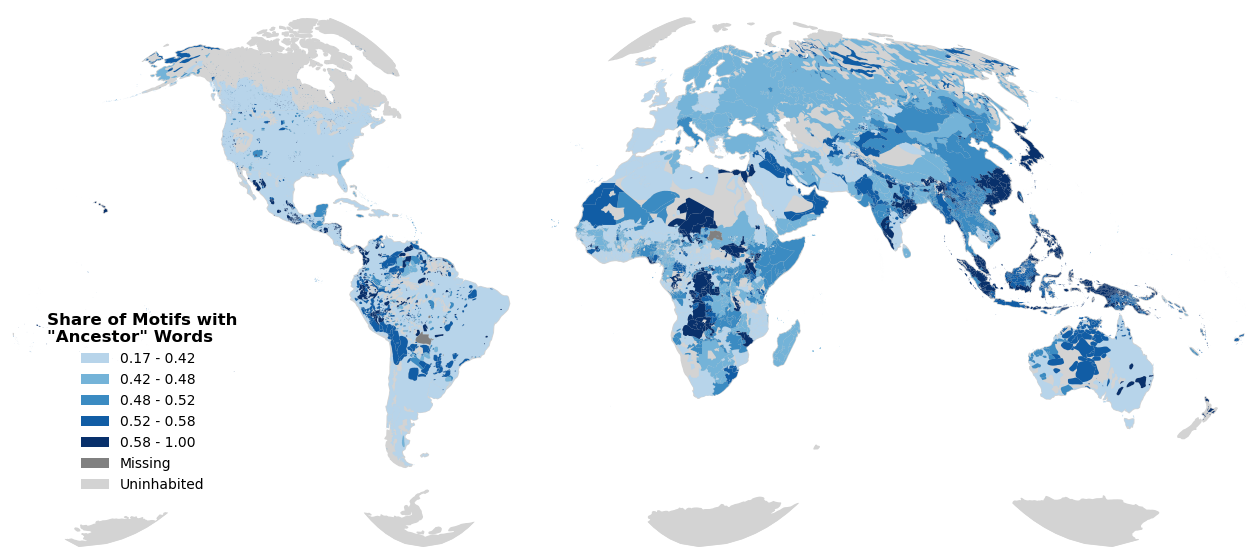

In [42]:
# Ancestors - Pos-Columbian (Goode Homolosine)
plot_goode_quantile_with_bins(
    poscol_shape, 'ancestor_sh', bins_anc, label_map_anc,
    "Share of Motifs with\n\"Ancestor\" Words",
    "Replication_AncestorSh_POSCOL_Goode.pdf")

### -- Map 3: Class Stratification

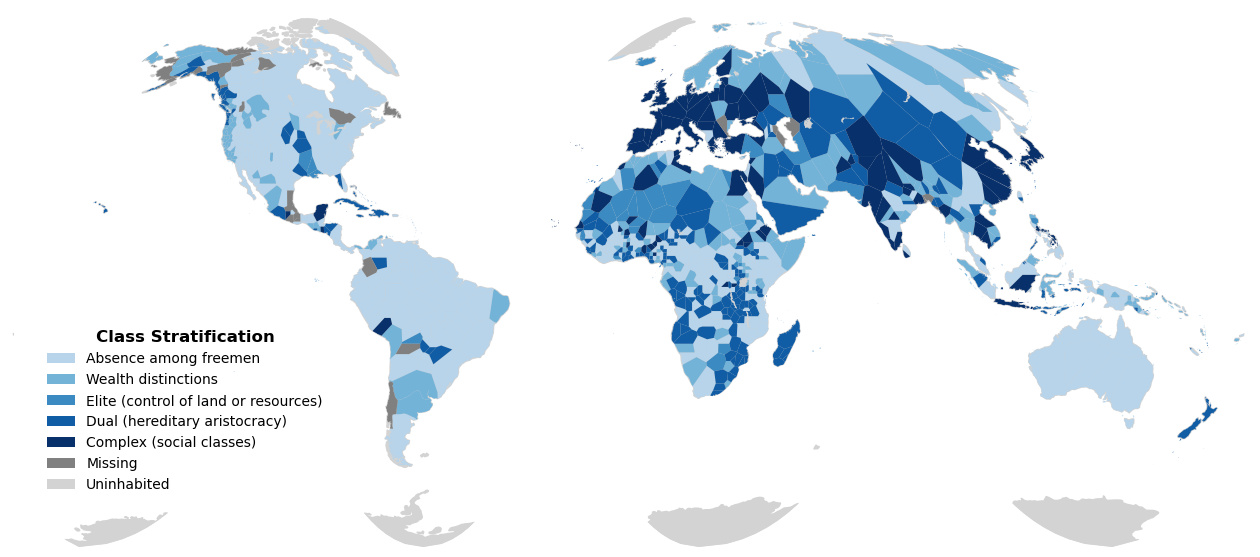

({np.float64(1.0): array([0.71618608, 0.83320261, 0.91615532, 1.        ]),
  np.float64(2.0): array([0.45603691, 0.70235321, 0.84707294, 1.        ]),
  np.float64(3.0): array([0.23034996, 0.54407545, 0.76180238, 1.        ]),
  np.float64(4.0): array([0.0684126 , 0.36505833, 0.64880476, 1.        ]),
  np.float64(5.0): array([0.03137255, 0.18823529, 0.41960784, 1.        ])},
 [np.float64(1.0),
  np.float64(2.0),
  np.float64(3.0),
  np.float64(4.0),
  np.float64(5.0)])

In [43]:
# Class Stratification - Pre-Columbian (Goode Homolosine)
label_map_class = {
    1: "Absence among freemen",
    2: "Wealth distinctions",
    3: "Elite (control of land or resources)",
    4: "Dual (hereditary aristocracy)",
    5: "Complex (social classes)"
}

plot_goode_categorical(precol_shape, 'v66', label_map_class,
                       "Class Stratification", "Replication_ClassStrati_PRECOL_Goode.pdf")

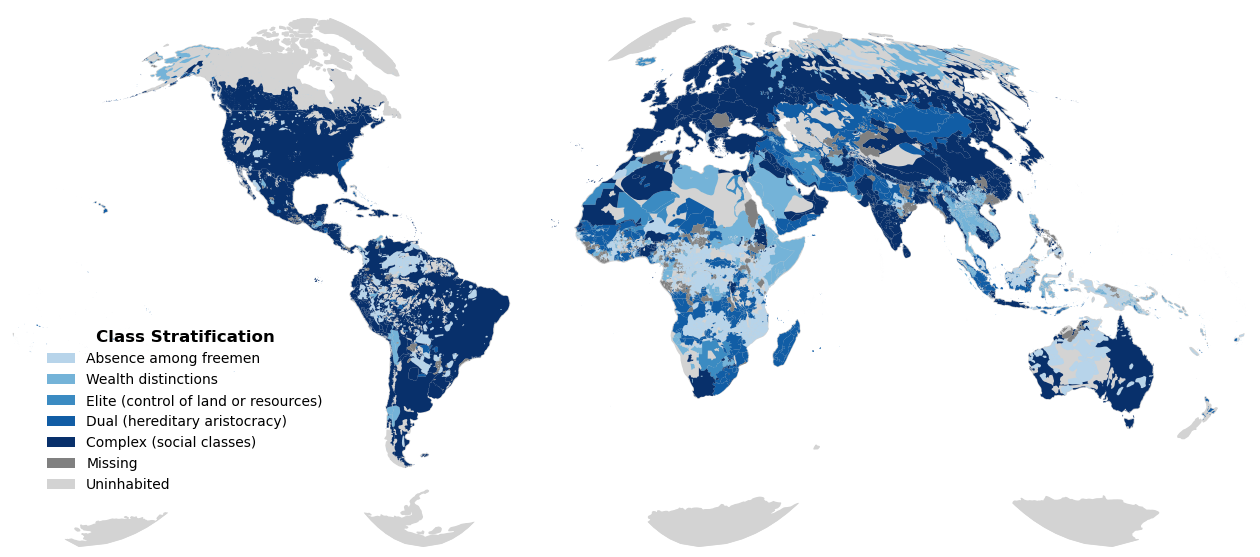

({np.float64(1.0): array([0.71618608, 0.83320261, 0.91615532, 1.        ]),
  np.float64(2.0): array([0.45603691, 0.70235321, 0.84707294, 1.        ]),
  np.float64(3.0): array([0.23034996, 0.54407545, 0.76180238, 1.        ]),
  np.float64(4.0): array([0.0684126 , 0.36505833, 0.64880476, 1.        ]),
  np.float64(5.0): array([0.03137255, 0.18823529, 0.41960784, 1.        ])},
 [np.float64(1.0),
  np.float64(2.0),
  np.float64(3.0),
  np.float64(4.0),
  np.float64(5.0)])

In [44]:
# Class Stratification - Pos-Columbian (Goode Homolosine)
plot_goode_categorical(poscol_shape, 'v66', label_map_class,
                       "Class Stratification", "Replication_ClassStrati_POSCOL_Goode.pdf")

## -- Map 4: Nature has Agency

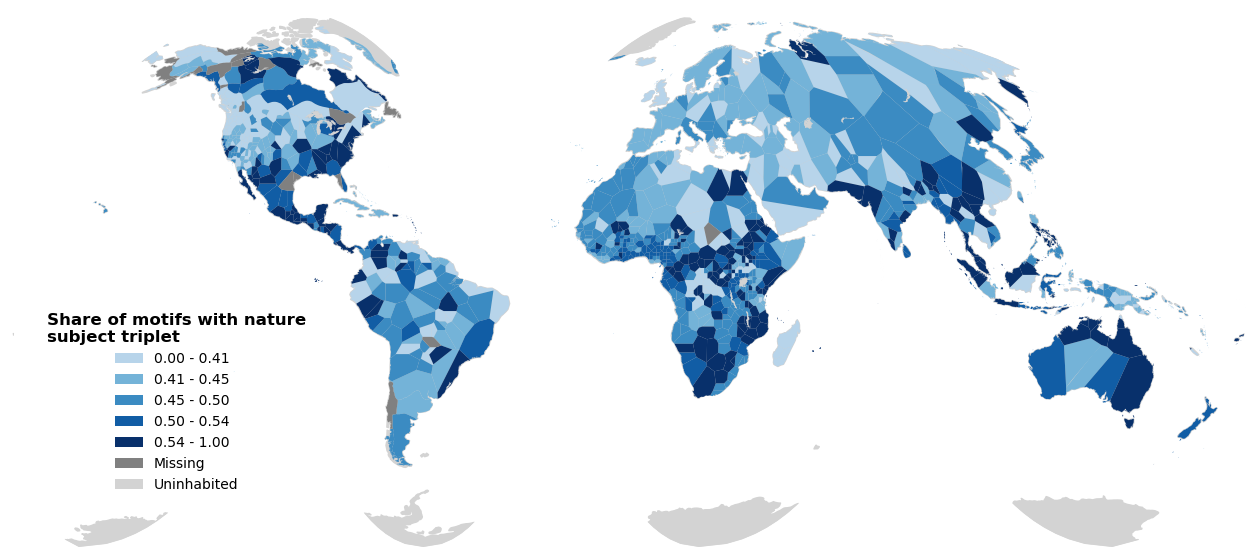

In [45]:
# Nature as Subject - Pre-Columbian (Goode Homolosine)
bins_nat_subj, label_map_nat_subj, _, _ = plot_goode_quantile(
    precol_shape, 'sh_nature_scl_only_atl', 5,
    "Share of motifs with nature\nsubject triplet",
    "Replication_NatureSubject_PRECOL_Goode.pdf")

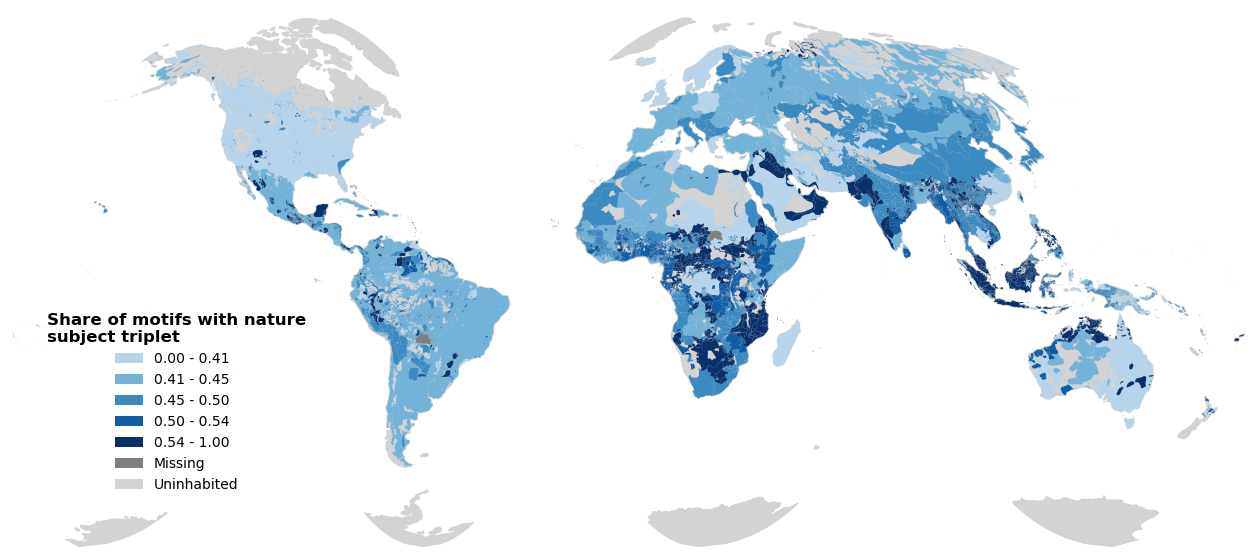

In [46]:
# Nature as Subject - Pos-Columbian (Goode Homolosine)
plot_goode_quantile_with_bins(
    poscol_shape, 'sh_nature_scl_only_atl', bins_nat_subj, label_map_nat_subj,
    "Share of motifs with nature\nsubject triplet",
    "Replication_NatureSubject_POSCOL_Goode.pdf")

### -- Map 5: Class Stratification (Dummy)

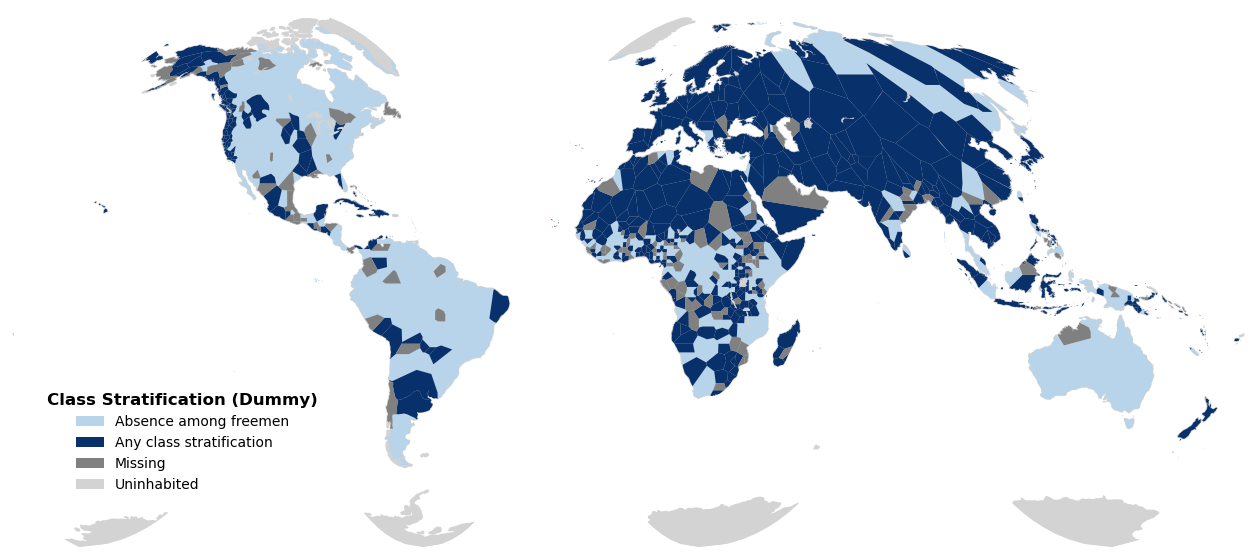

({np.float64(0.0): array([0.71618608, 0.83320261, 0.91615532, 1.        ]),
  np.float64(1.0): array([0.03137255, 0.18823529, 0.41960784, 1.        ])},
 [np.float64(0.0), np.float64(1.0)])

In [47]:
# Class Stratification Dummy - Pre-Columbian (Goode Homolosine)
label_map_dclass = {
    0: "Absence among freemen",
    1: "Any class stratification"
}

plot_goode_categorical(precol_shape, 'd_v66', label_map_dclass,
                       "Class Stratification (Dummy)", "Replication_D_ClassStrati_PRECOL_Goode.pdf")

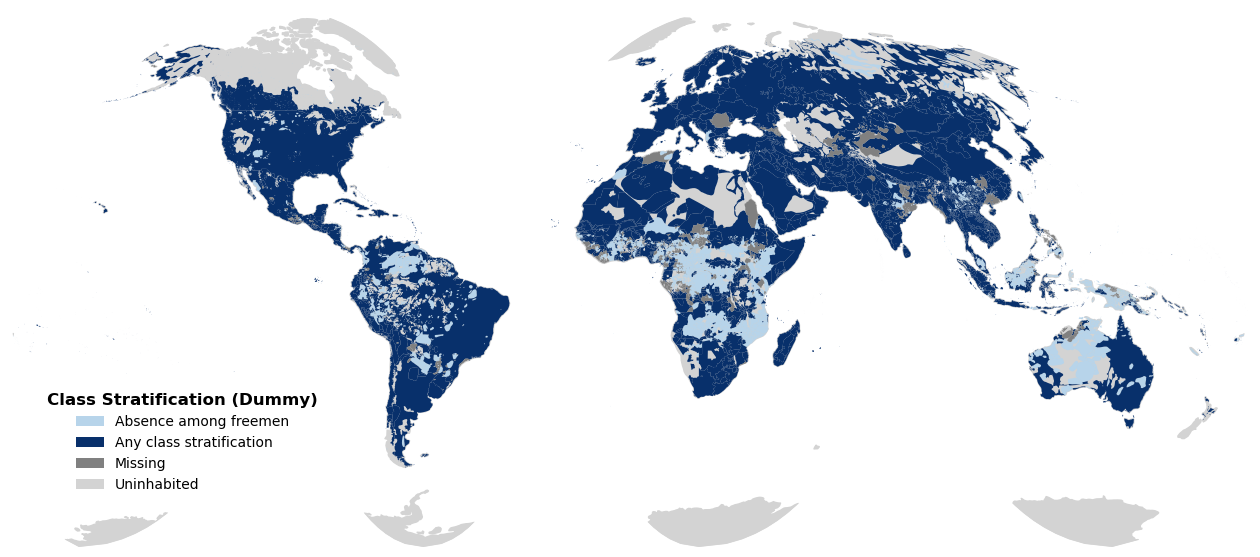

({np.float64(0.0): array([0.71618608, 0.83320261, 0.91615532, 1.        ]),
  np.float64(1.0): array([0.03137255, 0.18823529, 0.41960784, 1.        ])},
 [np.float64(0.0), np.float64(1.0)])

In [48]:
# Class Stratification Dummy - Pos-Columbian (Goode Homolosine)
plot_goode_categorical(poscol_shape, 'd_v66', label_map_dclass,
                       "Class Stratification (Dummy)", "Replication_D_ClassStrati_POSCOL_Goode.pdf")

## -- Map 6: Sex Differences in Agriculture

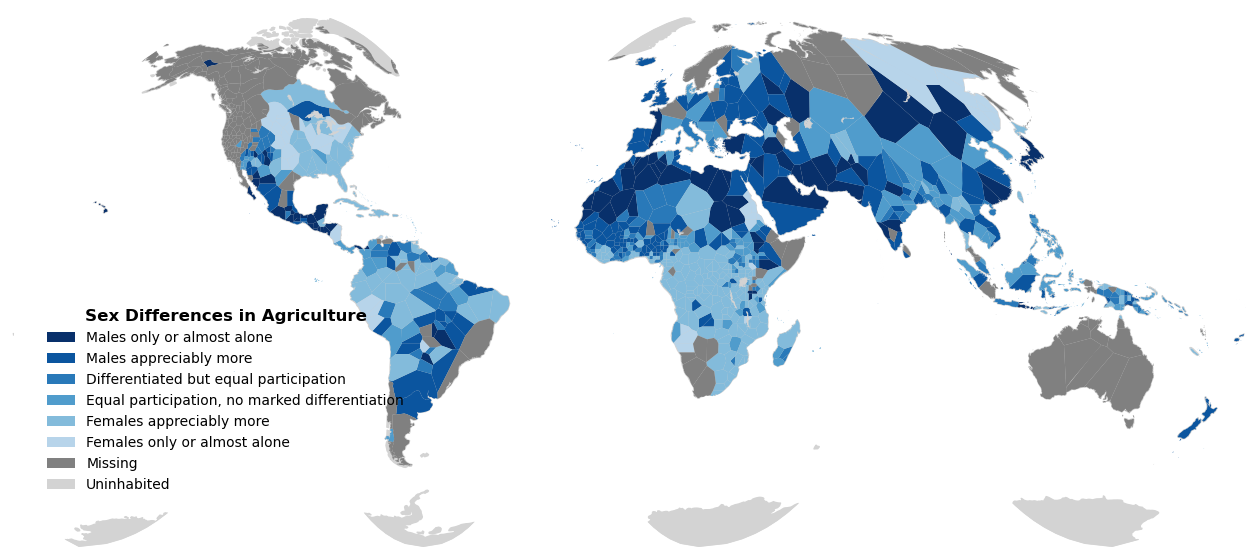

({np.float64(1.0): array([0.03137255, 0.18823529, 0.41960784, 1.        ]),
  np.float64(2.0): array([0.04282968, 0.33231219, 0.62322184, 1.        ]),
  np.float64(3.0): array([0.15965859, 0.47338408, 0.72538562, 1.        ]),
  np.float64(4.0): array([0.31519262, 0.61104498, 0.79846828, 1.        ]),
  np.float64(5.0): array([0.51309804, 0.73368089, 0.85938024, 1.        ]),
  np.float64(6.0): array([0.71618608, 0.83320261, 0.91615532, 1.        ])},
 [np.float64(1.0),
  np.float64(2.0),
  np.float64(3.0),
  np.float64(4.0),
  np.float64(5.0),
  np.float64(6.0)])

In [49]:
# Sex Differences in Agriculture - Pre-Columbian (Goode Homolosine)
label_map_sex = {
    1: "Males only or almost alone",
    2: "Males appreciably more",
    3: "Differentiated but equal participation",
    4: "Equal participation, no marked differentiation",
    5: "Females appreciably more",
    6: "Females only or almost alone"
}

plot_goode_categorical(precol_shape, 'v54', label_map_sex,
                       "Sex Differences in Agriculture", 
                       "Replication_SexDiffAgg_PRECOL_Goode.pdf", reverse=True)

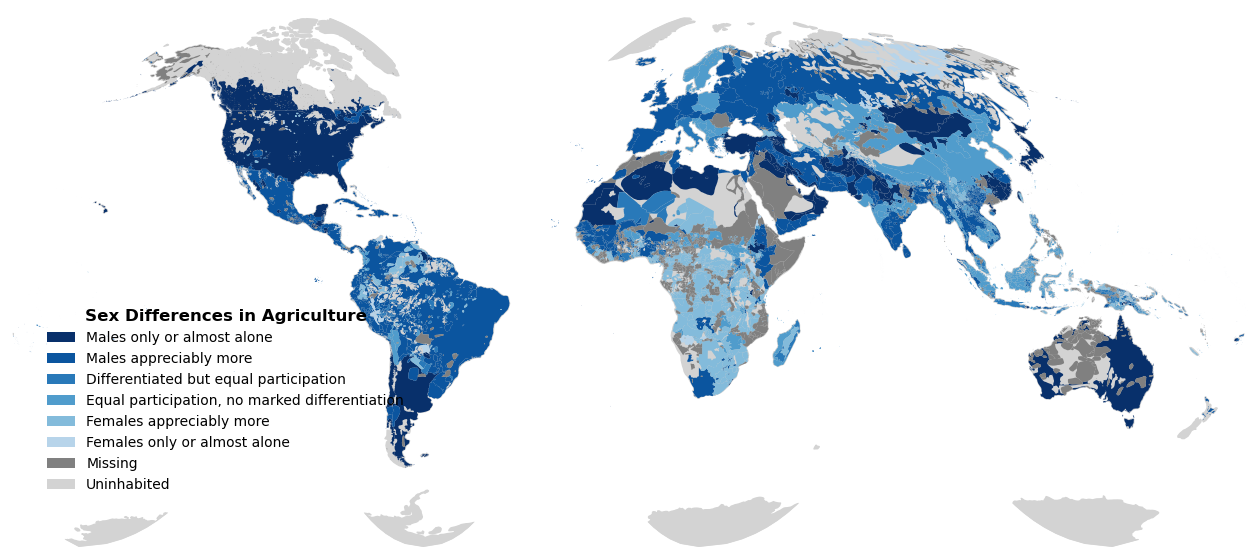

({np.float64(1.0): array([0.03137255, 0.18823529, 0.41960784, 1.        ]),
  np.float64(2.0): array([0.04282968, 0.33231219, 0.62322184, 1.        ]),
  np.float64(3.0): array([0.15965859, 0.47338408, 0.72538562, 1.        ]),
  np.float64(4.0): array([0.31519262, 0.61104498, 0.79846828, 1.        ]),
  np.float64(5.0): array([0.51309804, 0.73368089, 0.85938024, 1.        ]),
  np.float64(6.0): array([0.71618608, 0.83320261, 0.91615532, 1.        ])},
 [np.float64(1.0),
  np.float64(2.0),
  np.float64(3.0),
  np.float64(4.0),
  np.float64(5.0),
  np.float64(6.0)])

In [50]:
# Sex Differences in Agriculture - Pos-Columbian (Goode Homolosine)
plot_goode_categorical(poscol_shape, 'v54', label_map_sex,
                       "Sex Differences in Agriculture",
                       "Replication_SexDiffAgg_POSCOL_Goode.pdf", reverse=True)

## -- Map 7: Nature has Agency (Econ course maps)

### --- Nature as Subject or Object

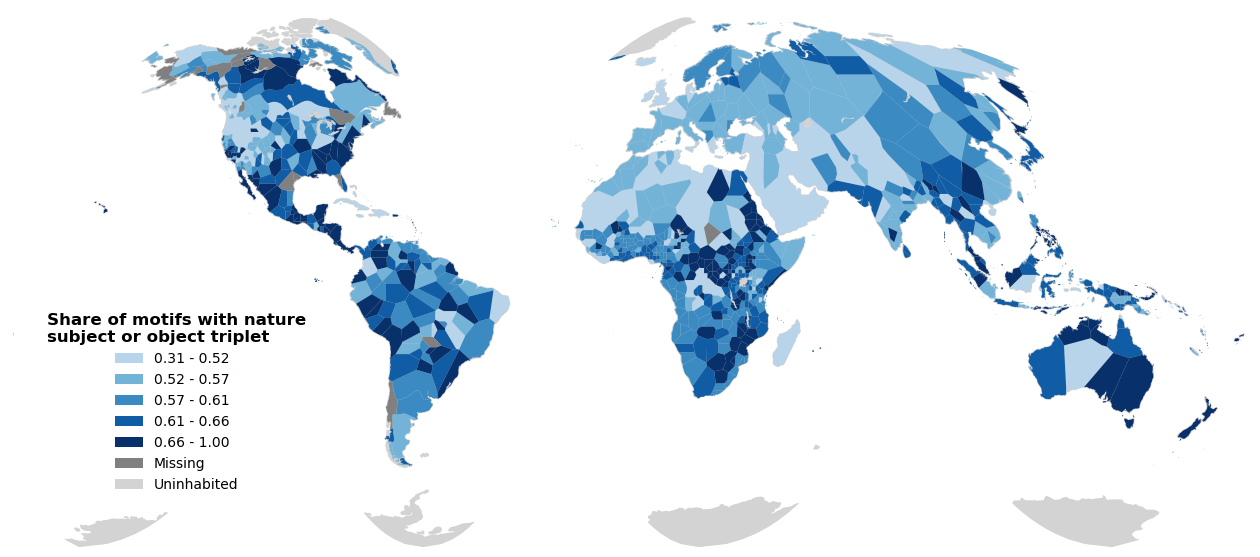

In [51]:
# Nature as Subject or Object - Pre-Columbian (Goode Homolosine)
bins_nat_any, label_map_nat_any, _, _ = plot_goode_quantile(
    precol_shape, 'sh_nature_scl_ocl_only_atl', 5,
    "Share of motifs with nature\nsubject or object triplet",
    "Replication_NatureAny_PRECOL_Goode.pdf")

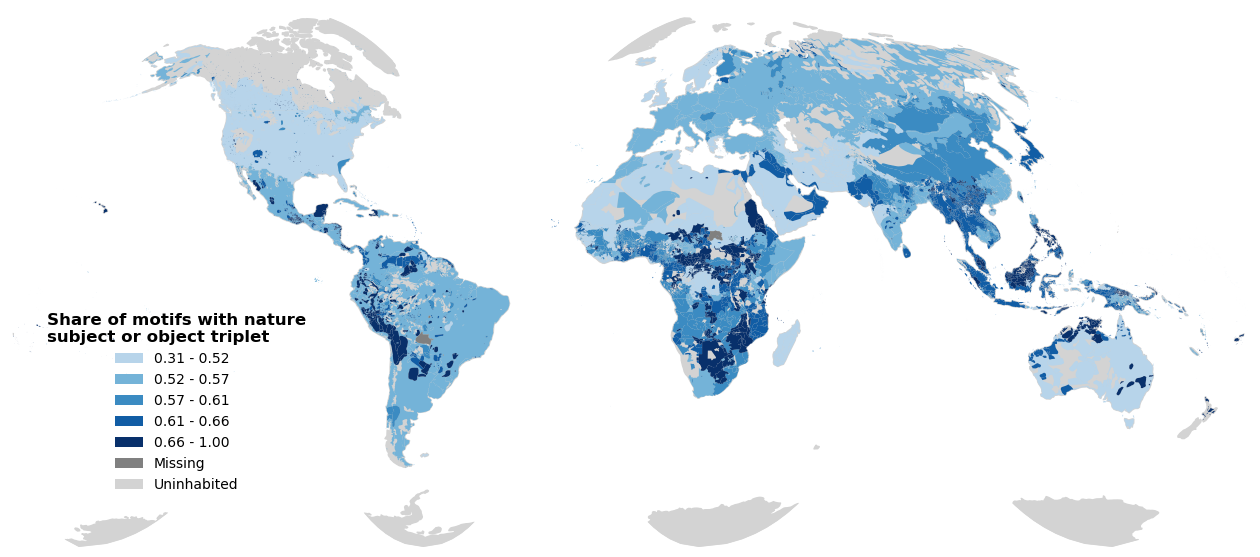

In [52]:
# Nature as Subject or Object - Pos-Columbian (Goode Homolosine)
plot_goode_quantile_with_bins(
    poscol_shape, 'sh_nature_scl_ocl_only_atl', bins_nat_any, label_map_nat_any,
    "Share of motifs with nature\nsubject or object triplet",
    "Replication_NatureAny_POSCOL_Goode.pdf")

### --- Nature as Object

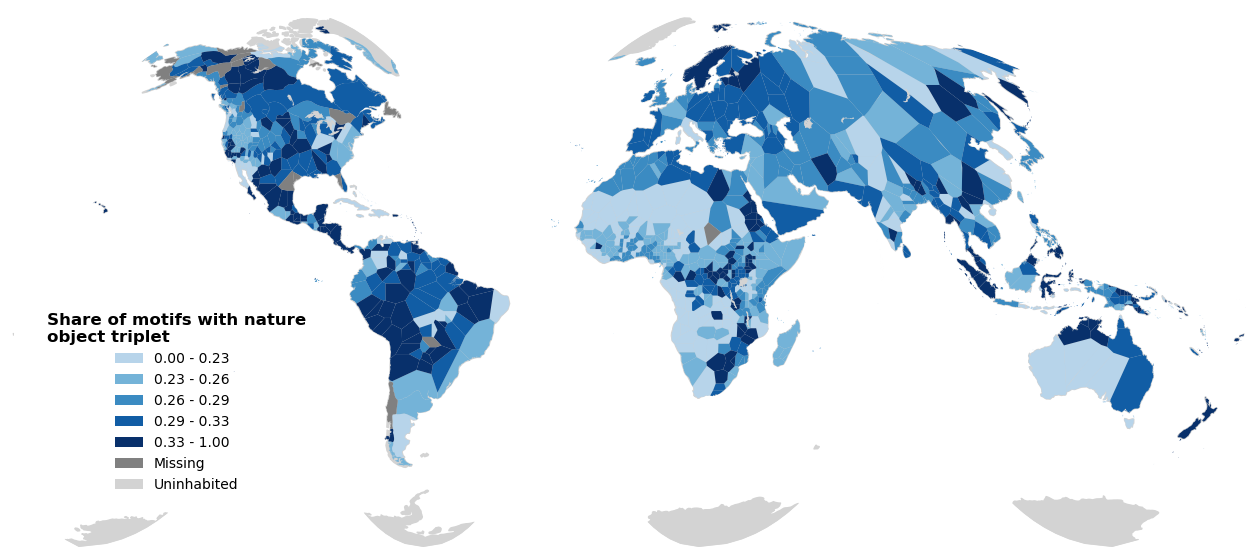

In [53]:
# Nature as Object - Pre-Columbian (Goode Homolosine)
bins_nat_obj, label_map_nat_obj, _, _ = plot_goode_quantile(
    precol_shape, 'sh_nature_ocl_only_atl', 5,
    "Share of motifs with nature\nobject triplet",
    "Replication_NatureObject_PRECOL_Goode.pdf")

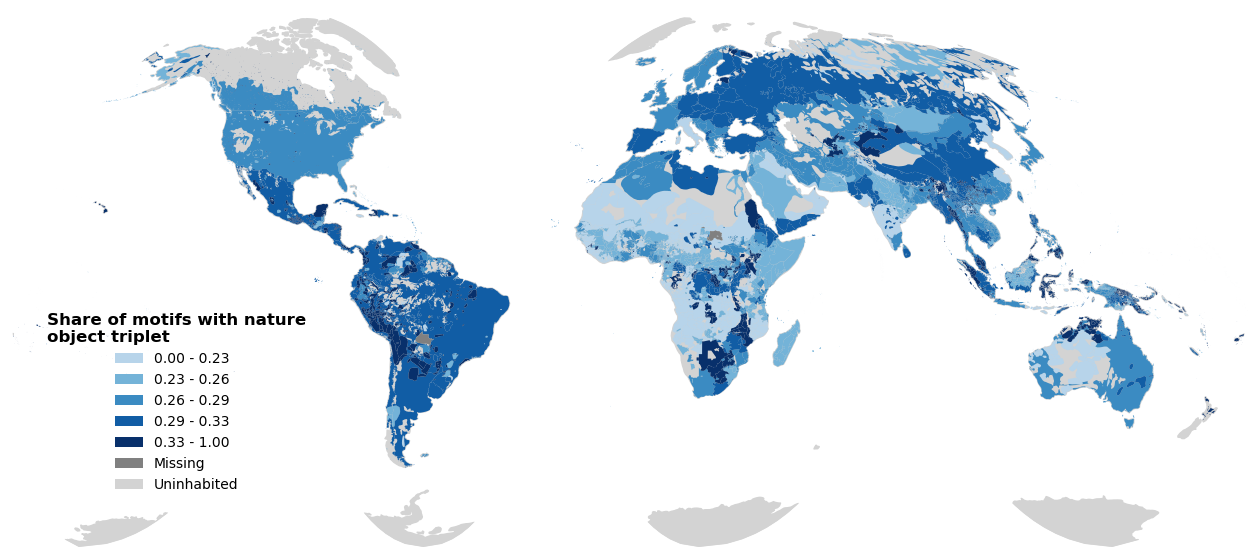

In [54]:
# Nature as Object - Pos-Columbian (Goode Homolosine)
plot_goode_quantile_with_bins(
    poscol_shape, 'sh_nature_ocl_only_atl', bins_nat_obj, label_map_nat_obj,
    "Share of motifs with nature\nobject triplet",
    "Replication_NatureObject_POSCOL_Goode.pdf")